# Customer Segmentation & Retention Strategy using Transactional Data



This project demonstrates an end-to-end customer segmentation and retention strategy built on transactional data. The objective is to identify high-value and high-risk customer segments, quantify churn risk, and support data-driven retention decisions through interpretable models, deployment, and monitoring.

## Dataset

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

Dataset Source : - https://archive-beta.ics.uci.edu/dataset/502/online+retail+ii


## Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset import 

We have imported the excel dataset into a pandas DataFrame. 

In [2]:
df = pd.concat(pd.read_excel("online_retail_II.xlsx", sheet_name=None).values())

Below are the top most 5 records of the dataset. 

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Basic Statistics of the Dataset 

Lets just see some of the basic statistics of the dataset 

In [4]:
df.shape

(1067371, 8)

In [5]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='str')

In [6]:
df.info()

<class 'pandas.DataFrame'>
Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[us]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  str           
dtypes: datetime64[us](1), float64(2), int64(1), object(3), str(1)
memory usage: 73.3+ MB


Dataset is having null values as expected 

In [7]:
df[["Quantity", "Price"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1067371.0,9.938898,172.705794,-80995.00,1.00,3.0,10.00,80995.0
Price,1067371.0,4.649388,123.553059,-53594.36,1.25,2.1,4.15,38970.0


Calling the method describe of the Pandas dataframe shows some summary statistics, such as mean, median, quartiles etcs , for the numerical columns Quantity and Price. This shows that both columns have negative values which doesn't make sense, you cannot buy less than 0 items and/or for a negative price.

In [8]:
df.duplicated().sum()

np.int64(34335)

Even the dataset is having duplicate records which need to be handled. 

## Exploratory Data Analysis

Let's explore the data then we shall move to cleaning and preprocessing the Data. 

In [9]:
df["Country"].nunique()

43

There are 43 unique countries in the dataset.

In [10]:
print(df["Country"].unique().tolist())

['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE', 'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria', 'Netherlands', 'Poland', 'Spain', 'Channel Islands', 'Italy', 'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden', 'United Arab Emirates', 'Finland', 'Switzerland', 'Unspecified', 'Malta', 'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore', 'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Lebanon', 'Korea', 'Brazil', 'Canada', 'Iceland', 'Saudi Arabia', 'Czech Republic', 'European Community']


Let's see the percentage of transactions in each country. 

In [11]:
(df["Country"].value_counts(normalize=True).head(10).map(lambda x: f"{x*100:.2f} %"))


Country
United Kingdom    91.94 %
EIRE               1.67 %
Germany            1.65 %
France             1.34 %
Netherlands        0.48 %
Spain              0.36 %
Switzerland        0.30 %
Belgium            0.29 %
Portugal           0.25 %
Australia          0.18 %
Name: proportion, dtype: str

Most of the transaction is from United Kingdom which is around 91 % and other transactions are mostly made by the neighboring countries like Ireland, Germany and France. 

Let's see the transaction period. 

In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Data ranges from {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")


Data ranges from 2009-12-01 07:45:00 to 2011-12-09 12:50:00


In [13]:

print(f"Number of transactions registered: {df['Invoice'].nunique()}")

Number of transactions registered: 53628


In [14]:

print(f"Number of Unique Products sold : {df['StockCode'].nunique()}")

Number of Unique Products sold : 5305


In [15]:
print(f"Number of Unique Customers : {df['Customer ID'].nunique()}")

Number of Unique Customers : 5942


Lets see how was the sales in each Month 

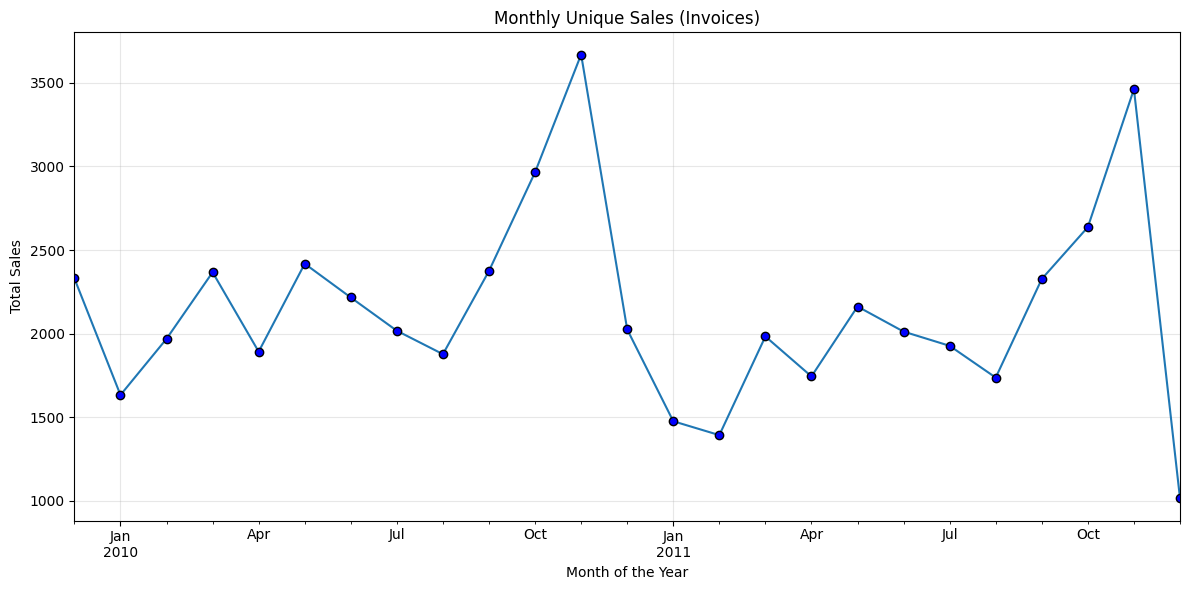

In [16]:
ax = (df.set_index("InvoiceDate").resample("ME")["Invoice"].nunique().plot(figsize=(12, 6),marker="o",linestyle="-",markerfacecolor="blue",markeredgecolor="black"))


ax.set_xlabel("Month of the Year")
ax.set_ylabel("Total Sales")
ax.set_title("Monthly Unique Sales (Invoices)")


ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


As expected there is huge increase in transaction during the september to december for both years. Major events like Halloween and Christmas are during that time. 

### Missing values in Dataset 

Let's check the missing and invalid values


In [17]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

#### Description 

There are 243007 null values as Customer ID and 4382 null values in description. Let first go through the null values in description column. 

In [18]:
print(f"Percentage of missing values in Description: {df['Description'].isnull().mean() * 100:.2f}%")

Percentage of missing values in Description: 0.41%


Percentage of missing values in the description column in 0.41 %. Another column with null values is Customer ID. We need to check whether the all column where description is null the customer ID also is null. Let see some sample of where description is null. 

In [19]:
df[df['Description'].isnull()].sample(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
128480,547347,22470,NaN,-6,2011-03-22 11:56:00,0.0,NaN,United Kingdom
6576,489901,21098,NaN,-200,2009-12-03 09:47:00,0.0,NaN,United Kingdom
136274,547959,20713,NaN,23,2011-03-28 15:19:00,0.0,NaN,United Kingdom
194360,507901,21169,NaN,-1,2010-05-11 17:07:00,0.0,NaN,United Kingdom
282290,561640,84802B,NaN,-125,2011-07-28 14:58:00,0.0,NaN,United Kingdom
436918,531160,47581B,NaN,-2,2010-11-05 14:20:00,0.0,NaN,United Kingdom
387139,570262,35954,NaN,-80,2011-10-10 10:00:00,0.0,NaN,United Kingdom
118250,500691,84925C,NaN,-29,2010-03-09 12:36:00,0.0,NaN,United Kingdom
524724,538138,72814,NaN,2,2010-12-09 15:57:00,0.0,NaN,United Kingdom
45722,493516,35990,NaN,2,2010-01-04 15:11:00,0.0,NaN,United Kingdom


Seeing this samples there is high chance that both are null. Let's check it 

In [20]:
all(df[df["Description"].isnull()]["Customer ID"].isnull())

True

In [21]:
(df[df["Description"].isnull()]["Quantity"] <= 0).mean() * 100

np.float64(61.364673664993155)

In [22]:
df[(df["Description"].isnull()) & (df["Country"] == "United Kingdom")].shape[0]

4382

In [23]:
all(df[df["Description"].isnull()]["Country"] == "United Kingdom")

True

In [24]:
df[(df["Description"].isnull()) & (df["Price"] == 0.0)].shape[0]

4382

In [25]:
all(df[df["Description"].isnull()]["Price"] == 0.0)

True

All records where the description is null in the same record price is 0.0 , quantity is negative and country of transaction is United Kingdom. This might be due returns, cancellation and refunds. This needs to be explored later. 

#### Customer ID

Let's now check the null values in Customer ID. 

In [26]:
print(f"Percentage of missing values in Customer ID: {df['Customer ID'].isnull().mean() * 100:.2f}%")

Percentage of missing values in Customer ID: 22.77%


Percentage of missing values in the description column in 22.77 %. This is lot more than that we had in description column. 

In [27]:
df[df['Customer ID'].isnull()].sample(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
502447,578844,22819,"BIRTHDAY CARD, RETRO SPOT",2,2011-11-25 16:14:00,0.42,NaN,United Kingdom
71308,495805,20748,KENSINGTON COFFEE SET,23,2010-01-26 17:51:00,8.47,NaN,United Kingdom
374161,569372,22668,PINK BABY BUNTING,1,2011-10-03 16:04:00,5.79,NaN,United Kingdom
26927,538524,21945,STRAWBERRIES DESIGN FLANNEL,2,2010-12-13 09:35:00,1.66,NaN,United Kingdom
297699,562955,84660c,PINK STITCHED WALL CLOCK,3,2011-08-11 10:14:00,7.46,NaN,United Kingdom
136628,502486,22329,ROUND CONTAINER SET OF 5 RETROSPOT,1,2010-03-24 17:43:00,3.36,NaN,United Kingdom
511967,579508,85032C,CURIOUS IMAGES GIFT WRAP SET,2,2011-11-29 16:33:00,1.63,NaN,United Kingdom
235458,557640,82583,HOT BATHS METAL SIGN,7,2011-06-21 16:24:00,4.96,NaN,United Kingdom
450776,575177,21902,"KEY FOB , FRONT DOOR",1,2011-11-08 18:41:00,1.63,NaN,United Kingdom
333143,521932,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-09-09 15:49:00,5.91,NaN,United Kingdom


In [28]:
all(df[df["Customer ID"].isnull()]["Description"].isnull())

False

In [29]:
df[df["Customer ID"].isnull()]["Description"].nunique()

4872

In [30]:
(df[df["Customer ID"].isnull()]["Quantity"] <= 0).mean() * 100

np.float64(1.7308143386816017)

In [31]:
df[(df["Customer ID"].isnull()) & (df["Price"] == 0.0)].shape[0]

6131

In [32]:
(df[df["Customer ID"].isnull()]["Price"] == 0.0).mean() *100

np.float64(2.522972589266976)

In [33]:
df[(df["Customer ID"].isnull()) & (df["Country"] == "United Kingdom")].shape[0]

240029

In [34]:
print (f"Percentage of missing Customer IDs in United Kingdom: {df[(df['Customer ID'].isnull()) & (df['Country'] == 'United Kingdom')].shape[0] / (df['Customer ID'].isnull().sum())*100:.2f}%")

Percentage of missing Customer IDs in United Kingdom: 98.77%


We didn't identify any clear pattens with the null values in Customer ID. As it is scattered and some are having price is 0.0 and quantity is negative. Since the majority of transaction is from United Kingdom. United Kingdom has contributed 98.77 % of null value. 

#### Price and Quantity 

Let's now check the prices and quantity. There were prices with 0.0 and quantity with negative values. 

In [35]:
(df["Price"] <= 0).mean() * 100

np.float64(0.5815222635803297)

In [36]:
(df["Price"] <= 0).sum()

np.int64(6207)

In [37]:
(df["Quantity"] <= 0).mean() * 100

np.float64(2.1501427338760375)

In [38]:
(df["Quantity"] <= 0).sum()

np.int64(22950)

There are 6207 records where price is less than 0 and 22950 records where quantity is less than 0 or 0. Let's see the sample data where quantity is less than 0 or 0. 

In [39]:

df[df["Quantity"] <= 0].sample(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
426670,530131,21316,NaN,-16,2010-11-01 15:28:00,0.00,NaN,United Kingdom
82999,497019,47595B,NaN,-9,2010-02-05 12:39:00,0.00,NaN,United Kingdom
347075,C523153,47590A,BLUE HAPPY BIRTHDAY BUNTING,-100,2010-09-20 15:00:00,4.65,16754.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
394065,C570867,21123,SET/10 IVORY POLKADOT PARTY CANDLES,-24,2011-10-12 16:17:00,1.25,12607.0,USA
323732,C520897,37501,TEA TIME TEA SET IN GIFT BOX,-1,2010-08-31 17:44:00,6.95,16658.0,United Kingdom
269567,C515468,84755,COLOUR GLASS T-LIGHT HOLDER HANGING,-144,2010-07-12 16:07:00,0.55,14882.0,United Kingdom
452688,C532403,85025B,EAU DE NILE HEART SHAPE PHOTO FRAME,-2,2010-11-11 19:35:00,1.65,15874.0,United Kingdom
385505,C570203,21530,DAIRY MAID TOASTRACK,-1,2011-10-07 16:49:00,0.79,15311.0,United Kingdom
449162,C532098,22889,"NUMBER TILE VINTAGE FONT, No",-13,2010-11-10 16:14:00,2.10,15031.0,United Kingdom


Exploring the sample we shall notice that some of the invoices are starting with "C". That indicates some cancellation has happened or invoice has been cancelled. Lets check what percentage of invoice starts with C against the total number of records where the quantity is less than 0 or 0. 

In [40]:

print(f"Percentage of negative quantity values that start with 'C': {df[df['Quantity'] <= 0]['Invoice'].astype('str').str.startswith('C').mean() * 100:.2f}%")

Percentage of negative quantity values that start with 'C': 84.94%


In [41]:

(df[df["Invoice"].astype("str").str.startswith("C")]["Quantity"] <= 0.).mean() * 100

np.float64(99.99487021647685)

So its clear 99 % of invoice starting with C is having quantity 0 or negative. 

# Preprocessing and Cleaning the Dataset

### Handling Missing Values

In [42]:
missing_data = df.isnull().sum()
missing_data

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [43]:
missing_data_percent = missing_data[missing_data>0] / df.shape[0] *100
missing_data_percent


Description     0.410541
Customer ID    22.766873
dtype: float64

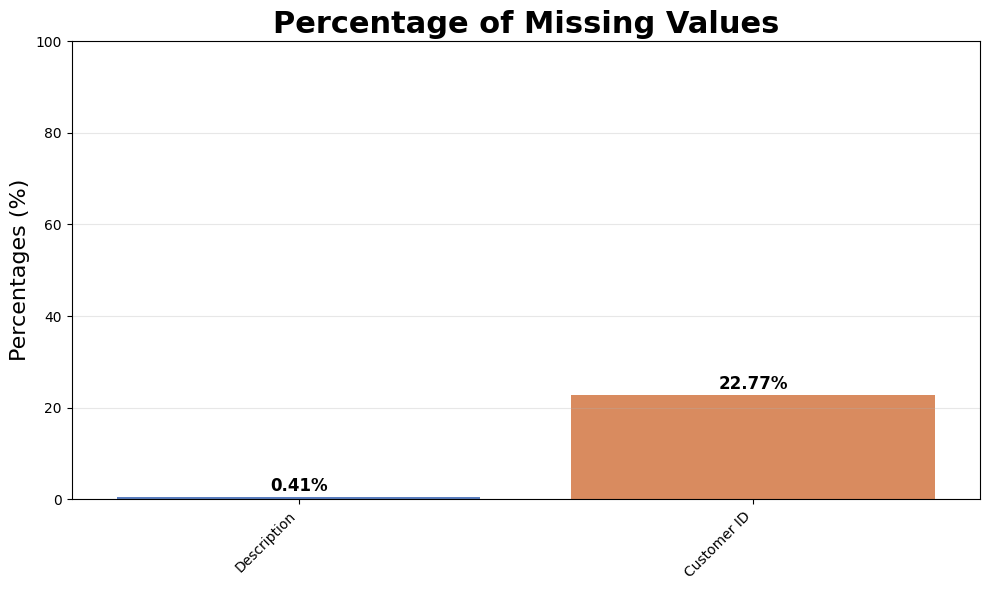

In [44]:
missing_data_percent = missing_data_percent.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x=missing_data_percent.index, y=missing_data_percent.values, hue=missing_data_percent.index,palette="muted",legend=False,ax=ax)



for i, value in enumerate(missing_data_percent.values):
    ax.text(i,value + 0.5,f"{value:.2f}%",ha="center",va="bottom",fontsize=12,fontweight="bold",color="black")

ax.set_ylim(0, 100)
ax.set_title("Percentage of Missing Values", fontsize=22, fontweight="bold")
ax.set_ylabel("Percentages (%)", fontsize=16)
ax.set_xlabel("")


plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


Customer ID is having almost 25% of missing values. Its not recommended to impute such a large percentage of  missing values this might cause bias or noise to the analysis. Customer segmentation is purely based on customer behavior and preference. So it is very important to have an accurate data. Description is having very negligible amount of missing values. Since it is a low impact categorical features, we have two options: Can drop this as the impact is less or can impute as "Unknown" and can be used as categorical feature. In this case i am imputing as "Unknown" for description and drop the Customer ID. 

In [45]:
df["Description"] = df["Description"].fillna("Unknown")
df = df.dropna(subset=['Customer ID'])

In [46]:
df.isnull().sum().sum()

np.int64(0)

In [47]:
df.shape

(824364, 8)

## Handling Duplicates 

In [48]:
df.duplicated().sum()

np.int64(26479)

we have 26479 duplicate rows. Since the accuracy of the Data is important for the prediction. It is important to remove these duplicates other it will result unwanted noise in the dataset. Removing these rows will help in achieving a cleaner dataset. 

In [49]:
df.drop_duplicates(inplace=True)

In [50]:
df.shape

(797885, 8)

### Treating Cancelled Transactions

In [53]:
df['Transaction_Status'] = np.where(df['Invoice'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop(['Customer ID','InvoiceDate'], axis=1)

,Quantity,Price
count,18390.000000,18390.000000
mean,-25.719195,24.240567
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,38970.000000
std,825.979381,428.241509


In [54]:
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

In [55]:
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.30%


All the quantity values that are negative correspond to cancelled transactions. The item value range from 0.01 to 38970 which indicate that the all items from low to high were cancelled. So it is recommended to retain this data as there will be some patterns and trends in cancellation that will be helpful in identifying the customer behavior. 

### Correcting StockCode Anomalies

In [65]:
unique_stock_codes = df['StockCode'].nunique()
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 4646


In [77]:
top_10_stock_codes = df["StockCode"].value_counts(normalize=True).head(10)
print(f"The top 10 most frequent stock codes are: {top_10_stock_codes}")

The top 10 most frequent stock codes are: StockCode
85123A    0.006462
22423     0.004610
85099B    0.004236
84879     0.003395
20725     0.003366
21212     0.003236
21232     0.002660
47566     0.002658
20727     0.002618
22383     0.002594
Name: proportion, dtype: float64


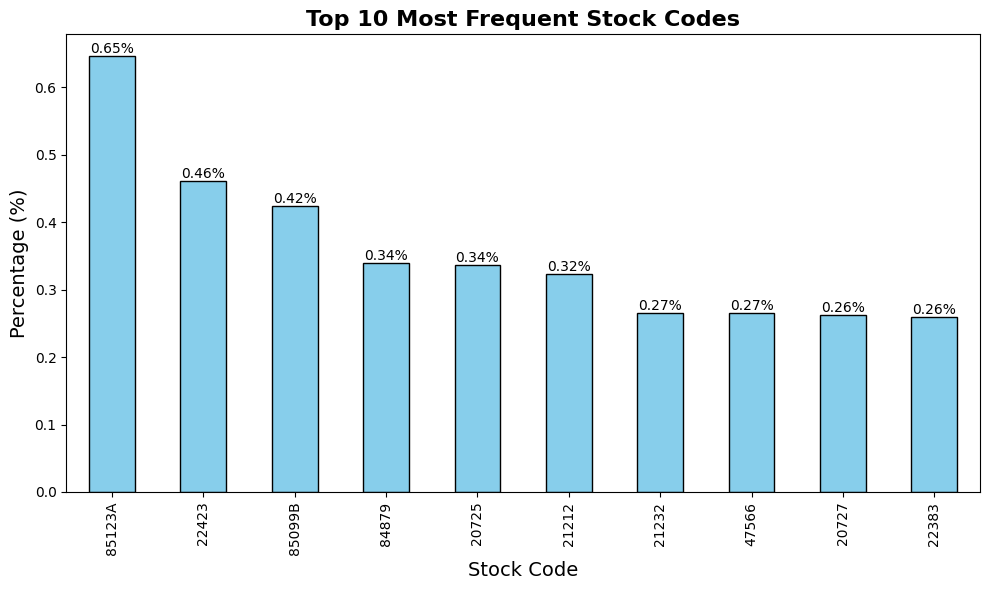

In [ ]:
plt.figure(figsize=(10, 6))
ax = (top_10_stock_codes * 100).plot(kind='bar',color='skyblue',edgecolor='black')
ax.set_title('Top 10 Most Frequent Stock Codes', fontsize=16, fontweight='bold')
ax.set_xlabel('Stock Code', fontsize=14)        
ax.set_ylabel('Percentage (%)', fontsize=14)


for i, val in enumerate(top_10_stock_codes * 100):
    ax.text(i, val, f"{val:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

The dataset is having 4646 unique stock code that is showing that the there is different range of products in the dataset. This will be used to understand the behavior of the customer. Exploring the top 10 frequent stock code will help to customer purchase frequency. Let's check if there is any anomaly in stock code. 

In [82]:
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()


print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    4633
0       8
1       2
3       2
4       1
Name: count, dtype: int64


We have just checked the numeric characters in the stock code and we found that the 4633 codes is having 5 numeric values and others are not in that pattern. Need to check which are those to confirm whether it is an anomaly or not. 

In [94]:
anomalous_stock_codes  = [ code for code in unique_stock_codes if sum(c.isdigit() for c in str(code))<=4]

print("Anomalous stock codes:")
print("-"*22)

for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
M
C2
BANK CHARGES
TEST001
TEST002
PADS
ADJUST
ADJUST2
SP1002
DOT
CRUK


In [97]:
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df) * 100)
print(f"Percentage of anomalous stock codes: {percentage_anomalous:.2f}%")

Percentage of anomalous stock codes: 0.46%


Total percentage of stock codes which are anomalous are 0.46 % which is very less compared to dataset. Only 13 out of 4646 unique stock code are deviating from the format. These are some Bank Charges, Post, Test etc which does not represent the actual data and this does not seem to be related to product purchase and need to be removed. 


In [101]:
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [103]:
df.shape[0]

794223